# DSCI 100 Project: Predicting Newsletter Subscription with KNN Classification

In [1]:
library(tidyverse)
library(tidymodels)
library(scales)
library(themis)
options(repr.matrix.max.rows = 6)

set.seed(1000)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## (1) Introduction

The Pacific Laboratory for Artificial Intelligence (PLAI), to advance embodied AI research, has set up a Minecraft server named PLAICRAFT to collect behavioural data on volunteer players. A portion of the data from PLAI's endeavours has been provided for this project: the `players.csv` data set. The details of `players.csv` are summarized below. See section 2.3.1 for the calculation of summary values reported here:

### (1.1) `players.csv`
This dataset contains the following 7 variables regarding 196 players from the server: 
|**Variable**|**Read Data Type**|**Proper Data Type**|**Description**|
|:-:|:-:|:-:|:-|
|experience|`chr`|`fct`|Self-evaluated Minecraft experience level. One of: *Beginner*, *Amateur*, *Regular*, *Pro* or *Veteran*.|
|subscribe|`lgl`|`fct`|Whether player is subscribed to a game-related newsletter. 144 are subscribed, 52 are not.|
|hashedEmail|`chr`|`chr`|Encrypted email.|
|played_hours|`dbl`|`dbl`|Hours played on the server. Mean = 5.8h, min = 0h, max = 223.1.|
|name|`chr`|`chr`|Player's auto-generated genric name.|
|gender|`chr`|`fct`| One of: *Male*, *Female*, *Non-binary*, *Agender*, *Two-spirited*, *Other* or *Perfer not to say*.|
|Age|`dbl`|`int`|Self-reported age. Players must be at least 7. The age selector had a maximum age of 99 and a default of 17. Mean = 20.5, min = 8, max = 50.|

**Potential issues:** 
- `subscribe` will need balancing for KNN classification.
- There are an inordinate number of 17-year-olds (see section 3.7) due to 17 being the default age on the given survey.
- The small sample size increases the effects of random unaccountable fluctuations in data.

### (1.2) Research Question
***Can the self-reported age, self-reported experience level, and the total hours played by a given player predict whether that player will be subscribed to receive a game-related newsletter, as determined with players in the PLAICRAFT Minecraft server?***

The `players.csv` dataset will be used. The `Age`, `experience`, `played_hours` and `subscribe` variables will be isolated. `Age`, `experience` and `played_hours` will then be selected via best-subset-selection and KNN classification to predict `subscribe`.

## (2) Methods & Results

### (2.1) Data Reading
Data will be read remotely from GitHub and stored in a tibble in `players`:

In [2]:
players_url <- "https://raw.githubusercontent.com/mke-l/dsci100-project-data/refs/heads/main/data/players.csv"
players_raw <- read_csv(players_url)

players_raw

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### (2.2) Data Cleaning and Wrangling
**(2.2.1)** Conversion of `players`' variables to proper data type, tidying of variable names, reordering of experience factor:

In [3]:
players_clean <- players_raw |>
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    rename(hashed_email = hashedEmail) |>
    mutate(gender = as_factor(gender)) |>
    rename(age = Age) |>
    mutate(age = as.integer(age)) |>
    mutate(experience = fct_relevel(experience, "Beginner", "Amateur", "Regular", "Pro", "Veteran"))

players_clean

experience,subscribe,hashed_email,played_hours,name,gender,age
<fct>,<fct>,<chr>,<dbl>,<chr>,<fct>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


**(2.2.2)** Isolation of relevant variables: `experience`, `subscribe`, `played_hours` and `age`:

In [4]:
players_wrangled <- players_clean |>
    select(experience, subscribe, played_hours, age)

players_wrangled

experience,subscribe,played_hours,age
<fct>,<fct>,<dbl>,<int>
Pro,TRUE,30.3,9
Veteran,TRUE,3.8,17
Veteran,FALSE,0.0,17
⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,17
Amateur,FALSE,2.3,17
Pro,TRUE,0.2,NA


### (2.3) Exploratory Numerical Data Analysis
**(2.3.1)** Computing mean, min and max values for all `players_wrangled` quantative variables:

In [5]:
players_stats <- players_wrangled |>
    select(played_hours, age) |>
    summarize(mean_played_hours = mean(played_hours),
             min_played_hours = min(played_hours),
             max_played_hours = max(played_hours),
             mean_age = mean(age, na.rm = TRUE),
             min_age = min(age, na.rm = TRUE),
             max_age = max(age, na.rm = TRUE))

players_stats

mean_played_hours,min_played_hours,max_played_hours,mean_age,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
5.845918,0,223.1,20.52062,8,50


It is noted that the average played hours of players on the PLAICRAFT server is 5.8 hours with a range of 0-223.1 hours. The average age of players on the PLAICRAFT server is 20.5 with a range of 8-50 years old.

**(2.3.2)** Distribution of players subscribed and not subscribed to the newsletter:

In [6]:
players_wrangled |>
    group_by(subscribed_to_newsletter = subscribe) |>
    summarize(count = n())

subscribed_to_newsletter,count
<fct>,<int>
FALSE,52
TRUE,144


This shows an considerable imbalence in the label, this will need to be balenced during later analysis.

### (2.4) Exploratory Visual Data Analysis

**(2.4.1)** Distribution of players by age:

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


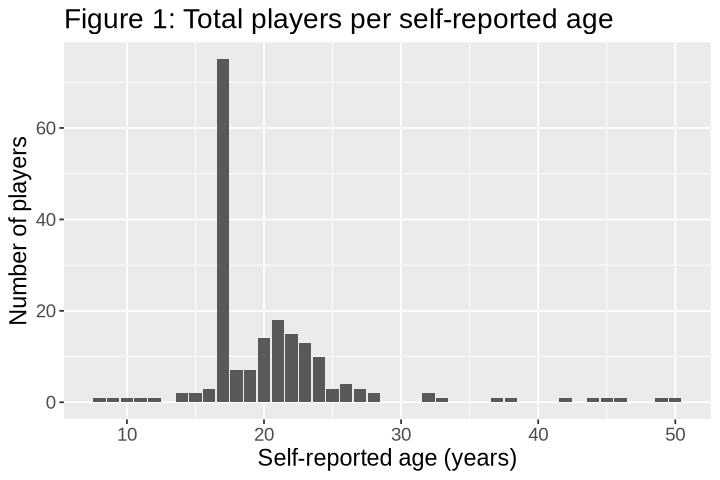

In [7]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(players_wrangled, aes(x = age)) +
    geom_bar(stat = "count") +
    labs(title = "Figure 1: Total players per self-reported age",
        x = "Self-reported age (years)",
        y = "Number of players") +
    theme(text = element_text(size = 14))

This shows that the general non-outlying data is symmetric around a mode of 21 years, with a longer tail towards higher ages since players must be at least 7 but can be up to 99. There is also an extreme spike at 17 years old due to 17 being the default age on the data collection survey (Pacific Laboratory of Artificial Intelligence, 2024).

**(2.4.2)** Fraction of players subscribed to the newsletter per experience level:

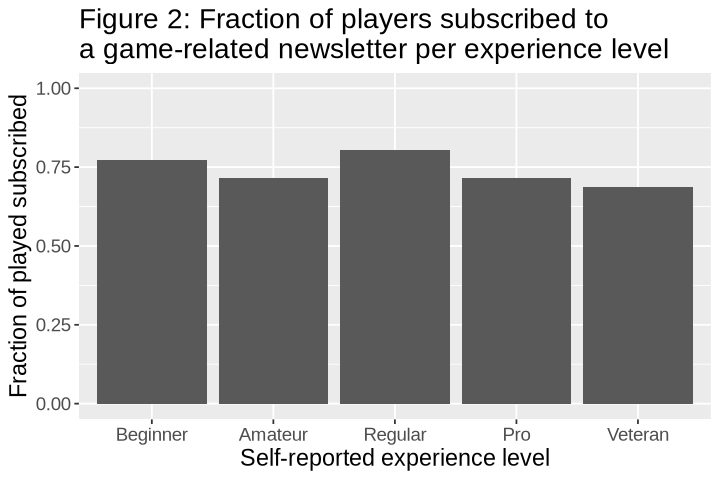

In [8]:
players_experience_count <- players_wrangled |>
    group_by(experience) |>
    summarize(total = n())

players_subscribed_experiance_count <- players_wrangled |>
    filter(subscribe == TRUE) |>
    group_by(experience) |>
    summarize(subscribed = n())

players_experience_subscribed_fraction <- players_experience_count |>
    bind_cols(subscribed = pull(players_subscribed_experiance_count, subscribed)) |>
    mutate(fraction = subscribed/total)


ggplot(players_experience_subscribed_fraction, aes(x = experience, y = fraction)) +
    geom_bar(stat = "identity") +
    ylim(c(0, 1)) +
    labs(title = "Figure 2: Fraction of players subscribed to \na game-related newsletter per experience level",
        x = "Self-reported experience level",
        y = "Fraction of played subscribed") +
    theme(text = element_text(size = 14))

There is a general downwards trend in subscriptions as experience increases with the exception of players of *Regular* experience. This shows experience may be a useful predictor of subscription.

**(2.4.3)** Total play time and age of each player colored according to subscription status:

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


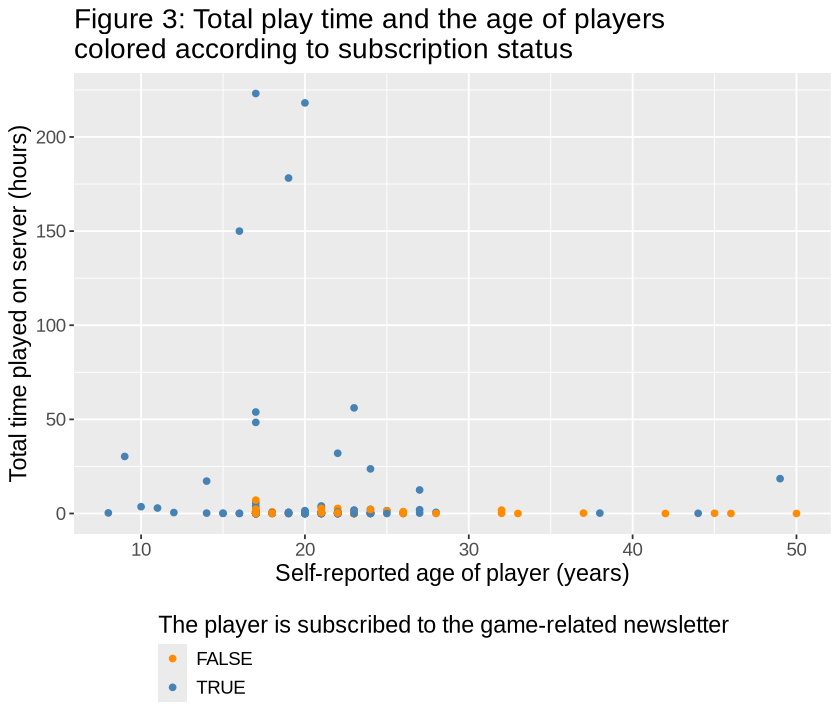

In [9]:
options(repr.plot.width = 7, repr.plot.height = 6)

players_time_vs_age <- ggplot(players_wrangled, aes(x = age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(title = "Figure 3: Total play time and the age of players \ncolored according to subscription status",
        x = "Self-reported age of player (years)",
        y = "Total time played on server (hours)",
        color = "The player is subscribed to the game-related newsletter") +
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 14),
         legend.position = "bottom",
         legend.direction = "vertical")

players_time_vs_age

Most players appear to have very low play time, except a few players with very high play time in the hundreds of hours. The below logarithmic time played scale shows a more detailed view of players:

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


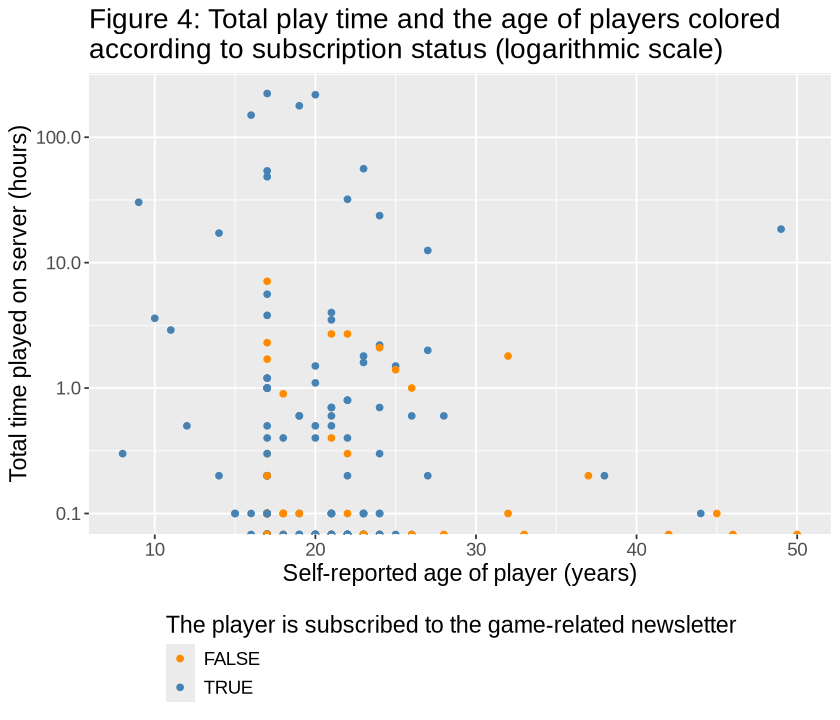

In [10]:
players_time_vs_age_log10 <- players_time_vs_age + 
    scale_y_log10() +
    ggtitle("Figure 4: Total play time and the age of players colored \naccording to subscription status (logarithmic scale)")

players_time_vs_age_log10

It is seen generally that players of higher playtime and lesser age are more likely to be subscribed to a game-related newsletter. Though the relationship is highly mixed, these two variables could both prove useful in predicting subscription.

### (2.5) Data Analysis

**(2.5.01)** Plan of analysis:

The experience levels *Beginner*, *Amateur*, *Regular*, *Pro* and *Veteran* will be recoded as integers 1-5, respectively. Observations with NAs will be dropped. The data will be split into 75% training and 25% testing data, and balanced over the `subscribe` variable. With the training data, best subset selection will determine which of `age`, `experience` and `played_hours` will be included in a KNN classification model to predict `subscribe`. 5-fold cross-validation will determine the optimal value for K. Finally, the resulting prediction model will be assessed with the test data.

The label is a boolean variable, making it suitable for classification. Best subset selection and cross-validation will ensure optimization of KNN classification. It is assumed that the bias in the age predictor for 17 will not have too great an effect on predictions. Although no predictor correlated strongly with the label, they are the best available choices.

**(2.5.02)** Mapping experience levels *Beginner*, *Amateur*, *Regular*, *Pro* and *Veteran* to integers 1-5:

In [11]:
players_integers <- players_wrangled |>
    mutate(experience = as.integer(experience))

players_integers

experience,subscribe,played_hours,age
<int>,<fct>,<dbl>,<int>
4,TRUE,30.3,9
5,TRUE,3.8,17
5,FALSE,0.0,17
⋮,⋮,⋮,⋮
2,FALSE,0.0,17
2,FALSE,2.3,17
4,TRUE,0.2,NA


**(2.5.03)** Dropping NAs (Since there's only two observations with NAs, this operation is applicable):

In [12]:
players <- players_integers |>
    drop_na()

players

experience,subscribe,played_hours,age
<int>,<fct>,<dbl>,<int>
4,TRUE,30.3,9
5,TRUE,3.8,17
5,FALSE,0.0,17
⋮,⋮,⋮,⋮
5,FALSE,0.3,22
2,FALSE,0.0,17
2,FALSE,2.3,17


**(2.5.04)** Creating the initial split with stratification over `subscribe`:

In [13]:
players_split <- players |>
    initial_split(prop = 0.75, strata = subscribe)

players_training <- training(players_split)
players_testing <- testing(players_split)

**(2.5.05)** Creating recipies for each subset with centering, scaling and upsampling (balance):

In [14]:
exp_recipe <- recipe(subscribe ~ experience, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE)

hrs_recipe <- recipe(subscribe ~ played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE)

age_recipe <- recipe(subscribe ~ age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE)

exp_hrs_recipe <- recipe(subscribe ~ experience + played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE)

exp_age_recipe <- recipe(subscribe ~ experience + age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE)

hrs_age_recipe <- recipe(subscribe ~ played_hours + age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE)

exp_hrs_age_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(subscribe, over_ratio = 1, skip = FALSE)

**(2.5.06)** Tuning model specification:

In [15]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


**(2.5.07)** 5-fold cross-validation specification:

In [24]:
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
players_vfold

Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 115, 116, 117

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NUL

## (3) Discussion

### (1.2) sessions.csv
This dataset contains the following 5 variables regarding 1535 distinct play sessions of various players from the server:
|**Variable**|**Read Data Type**|**Proper Data Type**|**Description**|
|:-:|:-:|:-:|:-|
|hashedEmail|`chr`|`chr`|Encrypted email|
|start_time|`chr`|`dttm`|Start time of session (dd/mm/yyyy hh/mm)|
|end_time|`chr`|`dttm`|End time of session (dd/mm/yyyy hh/mm)|
|original_start_time|`dbl`|`dbl`|Start time of session in UNIX format|
|original_end_time|`dbl`|`dbl`|End time of session in UNIX format|

**Potential Issues:** 
- `original_start_time` and `original_end_time` are in scientific notation when they should be a simple string of numbers, this renders them useless.

**Broad question**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific question**: 

## (4) References